In [42]:
import math
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt

In [43]:
def plot(data, title, color="blue", axes=None, y=None):
    if axes is None:
        plt.gca()
    else:
        plt.axes(axes)

    if y is None:
        plt.plot(data, '-', color=color, label=title)
    else:
        plt.plot(data, y, '-', color=color, label=title)
    plt.title(title)
    plt.legend(loc="best")

# data = np.random.randn(1000) # dummy data
# fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 5))
# plot(data, title="::title::", color="red", axes=axs[0])
# plot(data, title="::title::", color="blue", axes=axs[1])
# plt.show()

## Preprocessing

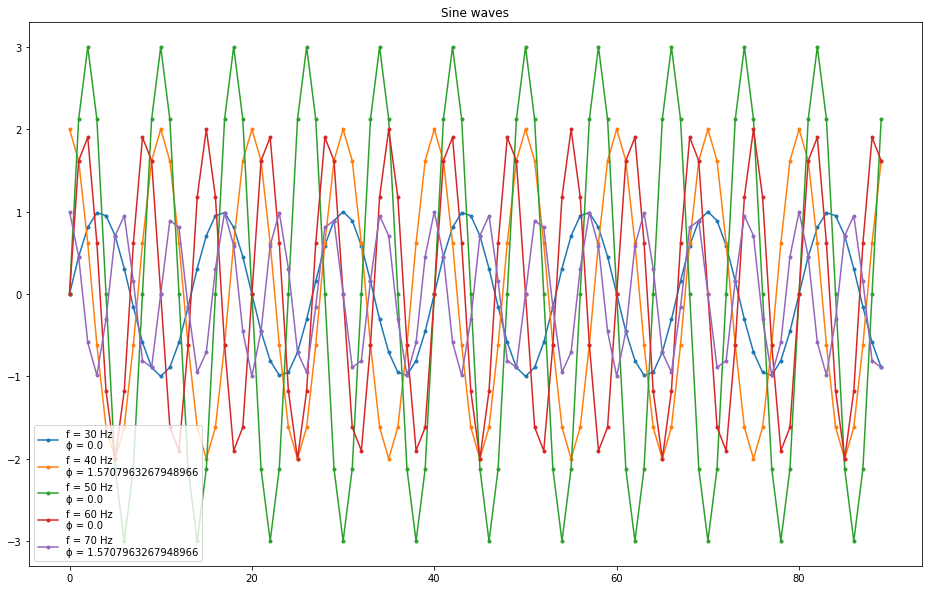

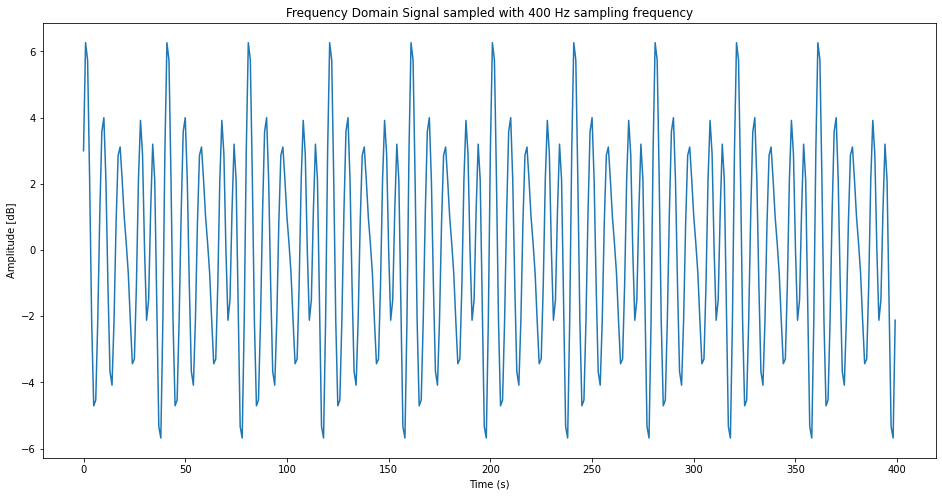

In [44]:
# Consider a fourier series with sum of sine waves: A sin(2 π f t + ϕ)
# A   | f (HZ) | ϕ (DEG) | t (SEC)
# ----|--------|----
# 1   | 30     | 0
# 2   | 40     | pi/2
# 3   | 50     | 0
# 2   | 60     | 0
# 1   | 70     | pi/2
# x(t) = A sin(2πft + φ) time domain.
# A in the Amplitude parameter. (signal magnitude)
# ϕ in radians in the Phase offset parameter.
# f in hertz in the Frequency parameter.
# x(t) = A exp(j(2πft + ϕ)) = A {cos(2πft + ϕ) + j sin(2πft + ϕ)}

# Question provied.
A = np.array([1, 2, 3, 2, 1])
f = np.array([30, 40, 50, 60, 70])
phi = np.array([0, np.pi/2, 0, 0, np.pi/2])

# Sampling into frequency domain.
sampling_freq = 400        # sampling frequency - samples per second
delta_t = 1/sampling_freq  # sampling period
freq_domain_signal = np.zeros(int(1/delta_t))
plt.figure(figsize=(16, 10)) # plot each Sin wave.
for i in range(len(A)):
    sine_waves = A[i]*np.sin(2*np.pi*f[i]*np.arange(0, 1, delta_t) + phi[i])
    plt.plot(sine_waves[:90], marker='.', label='f = ' + str(f[i]) + ' Hz' + '\n' + 'ϕ = ' + str(phi[i]))
    freq_domain_signal += A[i] * np.sin(2 * np.pi * f[i] * delta_t * np.arange(len(freq_domain_signal)) + phi[i])

plt.title("Sine waves")
plt.legend(loc='best')
plt.show()

# plot accumulated signal.
plt.figure(figsize=(16, 8))
plt.plot(freq_domain_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude [dB]')
plt.title('Frequency Domain Signal sampled with ' + str(sampling_freq) + ' Hz sampling frequency')
plt.show()

## Explanatory Analysis

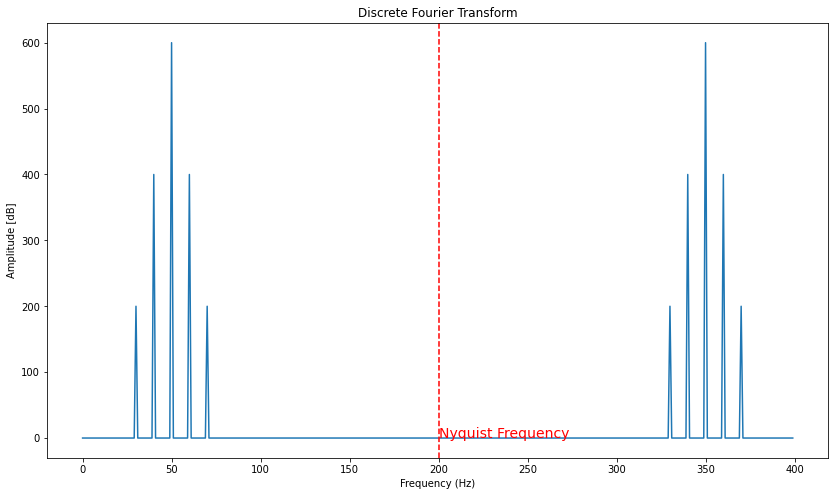

In [55]:
# Discrete Fourier Transformation of signal.
dft = np.fft.fft(freq_domain_signal)
plt.figure(figsize=(14, 8))
plt.plot(np.arange(len(dft)), np.abs(dft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.title('Discrete Fourier Transform')
plt.axvline(x=len(dft)/2, color='red', linestyle='--') # in order to mark nyquist frequency on plot.
plt.text(len(dft)/2, 0, 'Nyquist Frequency', color='red', fontsize=14) # # in order to mark nyquist frequency on plot.
plt.show()

## notch filter
[also more on calculations refer to next markdown section]

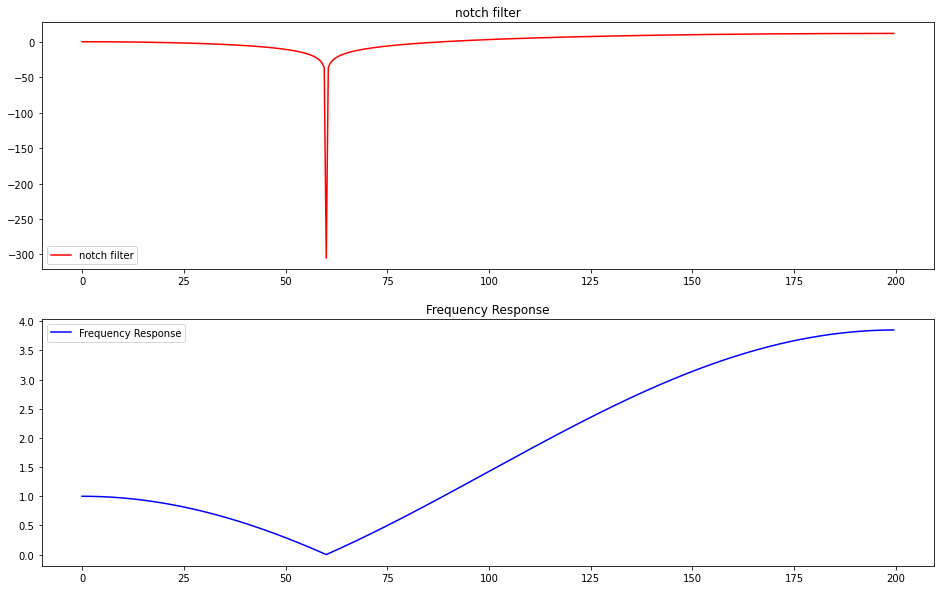

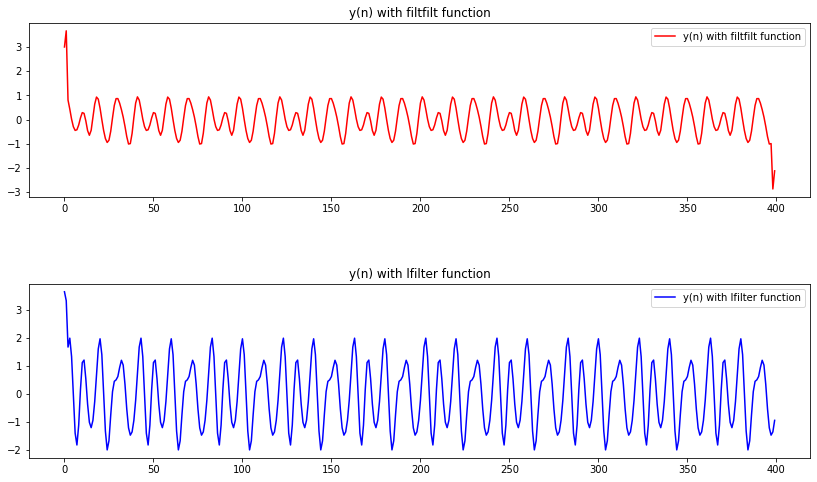

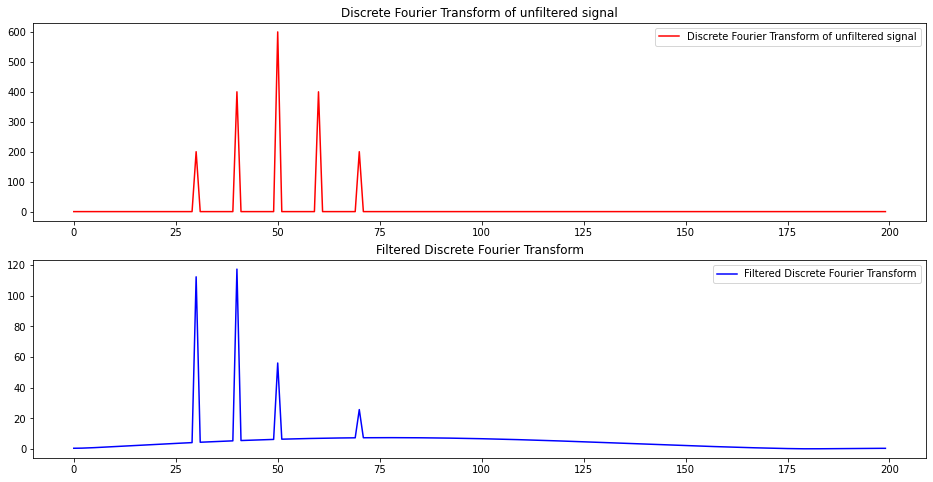

In [92]:
cutoff_freq = 60
sampling_freq = 400
# w_cutoff = np.rad2deg(2 * np.pi * cutoff_freq / sampling_freq) # there is no need to convert to degrees.
w_cutoff = 2 * np.pi * cutoff_freq / sampling_freq # 0.942477796076938
z_1 = math.cos(w_cutoff) + 1j * math.sin(w_cutoff)
z_2 = math.cos(w_cutoff) - 1j * math.sin(w_cutoff)

# Calculated by hand - more info on this next section in notebook.
# def notch_filter_z_transform(z_1, z_2):
#     H_1 = 1 - 1.175570504584946 + 0.9999999999999549
#     return [(1/H_1).real, (-(z_1+z_2)/H_1).real, (z_1*z_2/H_1).real]
# h_z = notch_filter_z_transform(z_1, z_2)
# print("noch coefficients: ", h_z) # [1.2129599990798616, -1.4259199981596693, 1.2129599990798616]

h_z = [1.2129599990798616.real, -1.4259199981596693.real, 1.2129599990798616.real]

w, h = sp.freqz(h_z, [1], sampling_freq) # we use freqz to get the frequency response of the filter
filtered_signal_filtfilt = sp.filtfilt(h_z, [1], freq_domain_signal) # we use filtfilt to apply the filter to the signal
filtered_signal_lfilter = sp.lfilter(h_z, [1], freq_domain_signal) # we use lfilter to apply the filter to the signal
filtered_dft = np.fft.fft(filtered_signal_filtfilt) # Discrete Fourier Transform of notch filtered signal.

# notch filter - Frequency response.
w = w / (2 * np.pi) * sampling_freq # scale w to be in Hz
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
plot(w, y=20 * np.log10(abs(h)), title="notch filter", color="red", axes=ax[0])
plot(w, y=np.abs(h), title="Frequency Response", color="blue", axes=ax[1])
plt.show()

# y(n) with two filter appliers.
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
plot(filtered_signal_filtfilt, title="y(n) with filtfilt function", color="red", axes=axs[0])
plt.subplots_adjust(hspace=0.5)
plot(filtered_signal_lfilter, title="y(n) with lfilter function", color="blue", axes=axs[1])
plt.show()

# Discrete Fourier Transform of unfiltered signal and filtered signal.
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plot(np.abs(dft[:int(sampling_freq/2)]), title="Discrete Fourier Transform of unfiltered signal", color="red", axes=axs[0])
plot(np.abs(filtered_dft[:int(sampling_freq/2)]), title="Filtered Discrete Fourier Transform", color="blue", axes=axs[1])

## Signal Structure
- Sin Wave

$$  A \sin{(2\pi ft + \phi)} $$

- data

<div align="center">

| A   | f (HZ) | ϕ (DEG) 
| :-  | :-     | :-     
| 1   | 30     | 0      
| 2   | 40     | pi/2   
| 3   | 50     | 0      
| 2   | 60     | 0      
| 1   | 70     | pi/2

</div>   

### **notch filter calculations**
---

$$H(z) = (1 - z_{1}z^{-1})(1 - z_{2} z^{-1})$$
$$= 1 - 2 \cos{(\omega_{0})} z^{-1} + (\sin^2{\omega_{0} + \cos^2{\omega_{0}}} ) z^{-2}$$

$$
= 1- z_{2}z^{-1} - z_{1}z^{-1} + z_{1}z_{2}z^{-2}
\\
= 1 - ( z_{2} + z_{1}) z^{-1} + (1)z^{-2}$$

$$ \underset{\Longrightarrow }{\div H(1)}  $$

$$\underbrace{\frac{1}{H(1)}}_{b_{1}} + \underbrace{\frac{-(z_{2}+ z_{1})}{H(1)}}_{b_{2}}z^{-1} + \underbrace{\frac{1}{H(1)}}_{b_3}z^{-2}$$

---

$$ w_0 = \frac{f_{0}}{f_{s}} 2 \pi = \frac{60}{400} 2 \pi  = 0.942477796076938 $$

---

$$ z_{1} = cos(0.942477796076938)+sin(0.942477796076938) ί = a + bί = 0.5877852522925 + 0.8090169943749ί \\
z_{2} = cos(0.942477796076938)+sin(0.942477796076938) ί = a - bί = 0.5877852522925 - 0.8090169943749ί $$

---

$$ 2 * a = 1.175570504584946 \\ 
a^{2} + b^{2} = 0.3454915028125579 + 0.654508497187397 = 0.9999999999999549 \approx 1 $$

---

$$ 
H(z) = 1 - 1.175570504584946 z^{-1} + (1)z^{-2}
$$

---

$$H(1) = 1 - 2 a z^{-1} - ( a^{2} + b^{2}) z^{-2}$$
$$= 1 - 2 a (1)^{-1} + (a^2 + b^2) (1)^{-2}$$
$$= 1 - (1.175570504584946)(1)^{-1} + (1) 1^{-2}$$
$$= 1 - 1.175570504584946 + 1 = 0.824429495415053161941153708538 \approx 0.8244$$

---

$$\text{In order to satisfy } \textbf{DC Gain = 1 :}$$
$$ \frac{H(z)}{H(1)} = 1.212959999 - 1.425919998 z^{-1} + 1.212959999079 z^{-2} $$

### EXTRA -- library notch filter 

notch coefficients
numerator: 
[ 0.98453371 -1.15738879  0.98453371]
denominator: 
[ 1.         -1.15738879  0.96906742]
[ 0.98453371 -1.15738879  0.98453371] 
 [ 1.         -1.15738879  0.96906742]


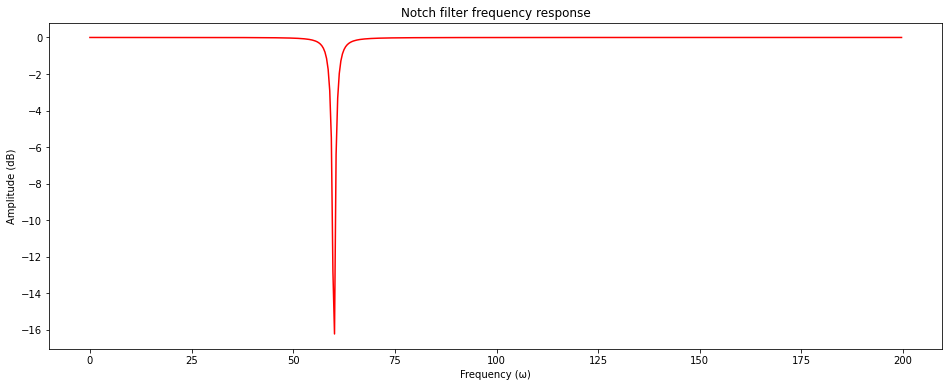

In [91]:
def notch_filter(f_sampling, f_cutoff):
    """
    Notch filter
    """
    nyquist_rate = f_sampling / 2
    normal_cutoff = f_cutoff / nyquist_rate
    b, a = sp.iirnotch(w0=normal_cutoff, Q=30)
    return b, a

f_cutoff = 60 # Hz (cutoff frequency)
f_sampling = 400 # Hz (sampling frequency)
b, a = notch_filter(f_sampling, f_cutoff)

print('notch coefficients' + "\nnumerator: \n" + str(b) + "\ndenominator: \n" + str(a))
print(b, "\n", a)

w, h = sp.freqz(b, a) # w is frequency in radians 
filtered_signal = sp.lfilter(b, a, freq_domain_signal)
w = w / (2 * np.pi) * f_sampling
# Magnitude Response, Bandwidth=0.2 radian/sample
plt.figure(figsize=(16, 6))
plt.plot(w, 20 * np.log10(abs(h)), color="red")
plt.xlabel('Frequency (ω)')
plt.ylabel('Amplitude (dB)')
plt.title('Notch filter frequency response')
plt.show()